In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

# Se la libreria del libro non serve togliamo
from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


# Simple Linear Regression
We will use the Boston housing dataset, contained in the ISLP package. The Boston dataset records the medv (average house value) for 506 neighbourhoods around Boston.

In [ ]:
# Importiamo il dataset dalla cartella del Git
Food = pd.read_csv("dataset/Food_Delivery_Times.csv")
Food.head()


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


# Fit Linear Model: Delivery_Time_min = b0 + b1*Distance_km + e

In [5]:
X = pd.DataFrame({'intercept': np.ones(Food.shape[0]), 'Distance_km': Food['Distance_km']})
X[:4]

,intercept,Distance_km
0,1.0,7.93
1,1.0,16.42
2,1.0,9.52
3,1.0,7.44


In [7]:
y = Food['Delivery_Time_min']
model = sm.OLS(y, X) #function to fit a simple linear regression. Here we define the model
results = model.fit() #here we fit the model

In [ ]:
summarize(results) #produces a simple table of the parameter estimates, their standard errors, t-statistics and p-values
# Distance_km ha Pvalue = 0, quindi è molto rilevante. 
# Il coefficiente è positivo, quindi all'aumentare della distanza aumenta il tempo di attesa. 
# L'intercetta ha un valore alto, quindi la distanza da sola non spiega sufficientemente i tempi di consegna

,coef,std err,t,P>|t|
intercept,26.2918,0.885,29.695,0.0
Distance_km,3.0259,0.077,39.506,0.0


### Creating the input matrix using ModelSpec of ISLP package

In [9]:
model = MS(['Distance_km'])
model = model.fit(Food) #checks that the lstat column is present in the Boston dataset
X = model.transform(Food)#constructs the input matrix with the intercept column
#NB: These two methods can be combined in a single method called fit_transform and can also handle more complex cases of pre-processing
X[:4]

,intercept,Distance_km
0,1.0,7.93
1,1.0,16.42
2,1.0,9.52
3,1.0,7.44


In [10]:
#Get predictions on new input
new_df = pd.DataFrame({'Distance_km':[10, 12, 14, 16, 20]})
newX = model.transform(new_df) #create the new data matrix with the transform method of the previously defined model
newX

,intercept,Distance_km
0,1.0,10
1,1.0,12
2,1.0,14
3,1.0,16
4,1.0,20


In [ ]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([56.55053848, 62.60228183, 68.65402518, 74.70576853, 86.80925524])

In [12]:
#Confidence interval
new_predictions.conf_int(alpha=0.05)

array([[55.69469872, 57.40637823],
       [61.69817688, 63.50638677],
       [67.61331576, 69.6947346 ],
       [73.46905   , 75.94248707],
       [85.08749891, 88.53101157]])

C:\Users\Asus\AppData\Local\Temp\ipykernel_15452\3870183372.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)


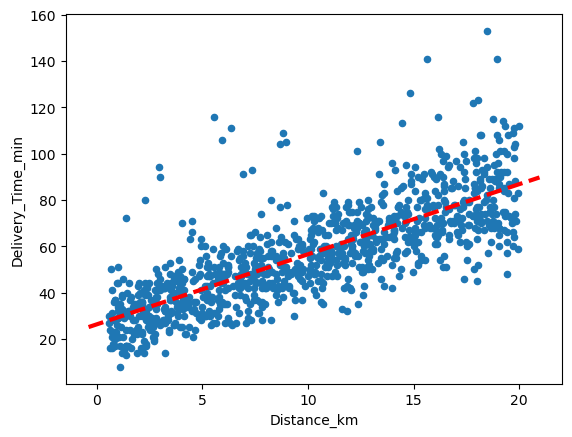

In [ ]:
#Plotting the regression line
def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = Food.plot.scatter('Distance_km', 'Delivery_Time_min')
abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)

# Il modello sembra essere lineare

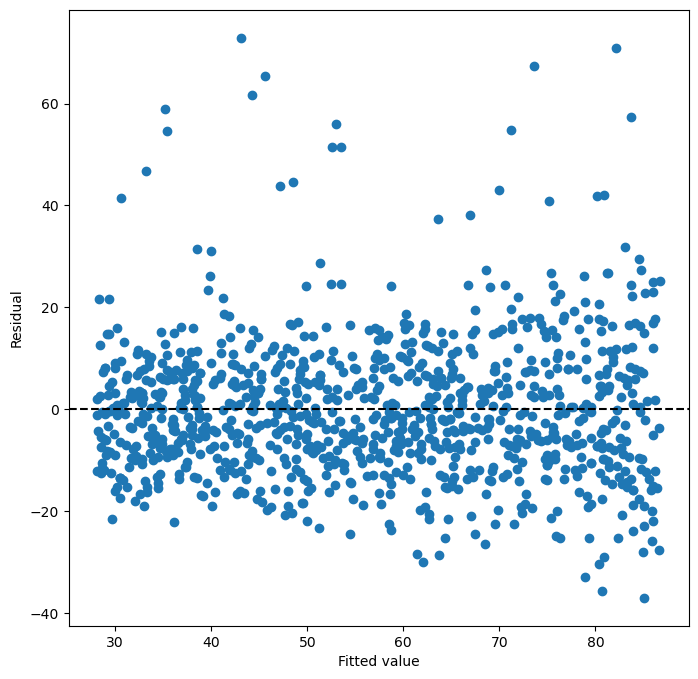

In [ ]:
# Diagnostics plot (We observe non linearity)
fig, ax = plt.subplots(figsize=(8, 8)) 
ax.scatter(results.fittedvalues, results.resid)  # Scatter plot of fitted values vs residuals
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')  
# La linearità sembra essere confermata anche da questo grafico 

np.int64(403)

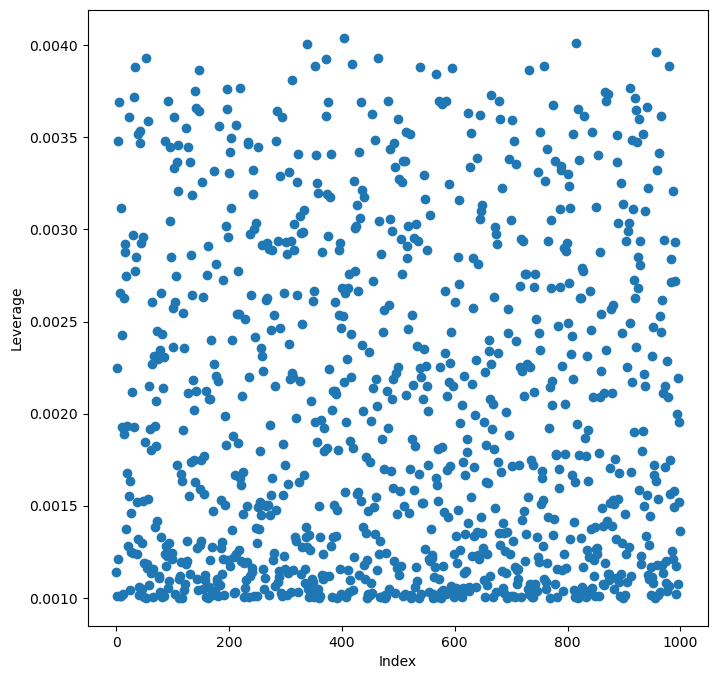

In [ ]:
# Compute leverage statistics
infl = results.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)
# Il livello di Leverage per gli outliers è 0.0040. Siccome quasi tutti i dati sono sotto la soglia possiamo dire che il modello è ben bilanciato,
# inoltre i dati hanno un’influenza relativamente bassa sul modello perchè hanno Leverage basso.

# Fit Linear Model: Delivery_Time_min = b0 + b1*Preparation_Time_min + e

In [42]:
X = pd.DataFrame({'intercept': np.ones(Food.shape[0]), 'Preparation_Time_min': Food['Preparation_Time_min']})
X[:4]

,intercept,Preparation_Time_min
0,1.0,12
1,1.0,20
2,1.0,28
3,1.0,5


In [28]:
y = Food['Delivery_Time_min']
model = sm.OLS(y, X) #function to fit a simple linear regression. Here we define the model
results = model.fit() #here we fit the model

In [ ]:
summarize(results) #produces a simple table of the parameter estimates, their standard errors, t-statistics and p-values
# Preparation_Time_min ha Pvalue = 0, quindi è molto rilevante. 
# Il coefficiente è positivo, quindi all'aumentare del tempo di preparazione aumenta il tempo di attesa. 
# L'intercetta ha un valore alto, quindi il tempo di preparazione è rilevante ma da solo non spiega sufficientemente i tempi di consegna

,coef,std err,t,P>|t|
intercept,40.7425,1.702,23.936,0.0
Preparation_Time_min,0.9416,0.092,10.203,0.0


### Creating the input matrix using ModelSpec of ISLP package

In [34]:
model = MS(['Preparation_Time_min'])
model = model.fit(Food) #checks that the lstat column is present in the Boston dataset
X = model.transform(Food)#constructs the input matrix with the intercept column
#NB: These two methods can be combined in a single method called fit_transform and can also handle more complex cases of pre-processing
X[:4]

,intercept,Preparation_Time_min
0,1.0,12
1,1.0,20
2,1.0,28
3,1.0,5


In [35]:
#Get predictions on new input
new_df = pd.DataFrame({'Preparation_Time_min':[10, 12, 14, 16, 20]})
newX = model.transform(new_df) #create the new data matrix with the transform method of the previously defined model
newX

,intercept,Preparation_Time_min
0,1.0,10
1,1.0,12
2,1.0,14
3,1.0,16
4,1.0,20


In [43]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([50.15805113, 52.04116453, 53.92427792, 55.80739132, 59.57361812])

In [37]:
#Confidence interval
new_predictions.conf_int(alpha=0.05)

array([[48.34178569, 51.97431656],
       [50.45554104, 53.62678802],
       [52.51292752, 55.33562833],
       [54.49135769, 57.12342495],
       [58.1597607 , 60.98747553]])

C:\Users\Asus\AppData\Local\Temp\ipykernel_15452\2484761485.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)


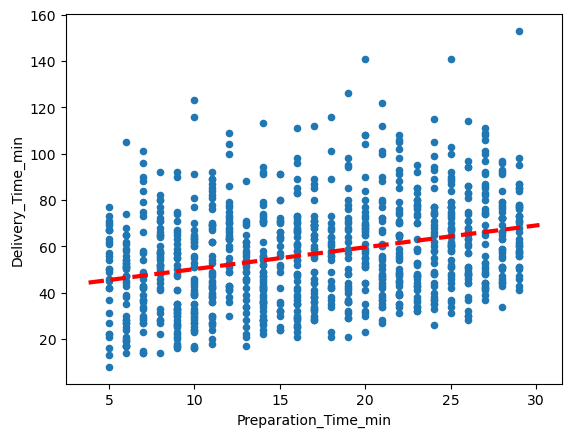

In [39]:
#Plotting the regression line
def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = Food.plot.scatter('Preparation_Time_min', 'Delivery_Time_min')
abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)

# Il modello sembra essere lineare

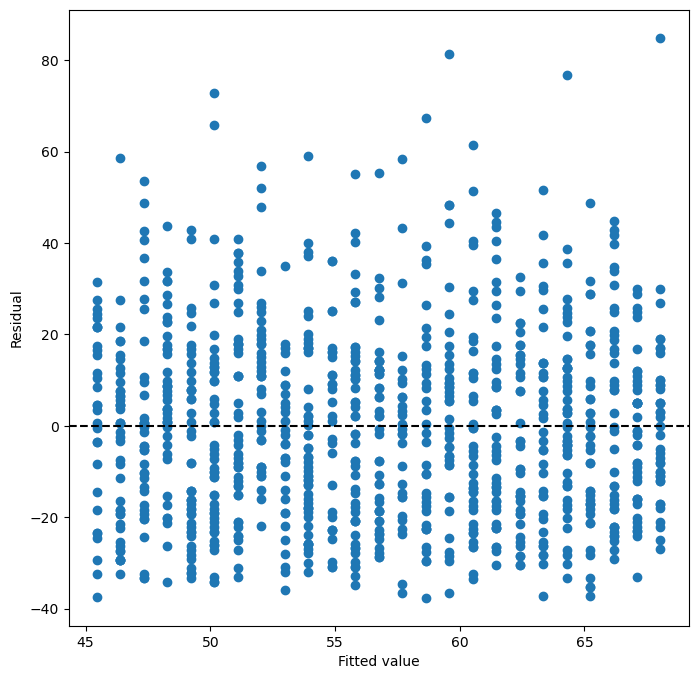

In [ ]:
# Diagnostics plot (We observe non linearity)
fig, ax = plt.subplots(figsize=(8, 8)) 
ax.scatter(results.fittedvalues, results.resid)  # Scatter plot of fitted values vs residuals
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')  
# La linearità sembra essere confermata anche da questo grafico, il tempo di preparazione è rilevante ma da solo non spiega sufficientemente i tempi di consegna

np.int64(9)

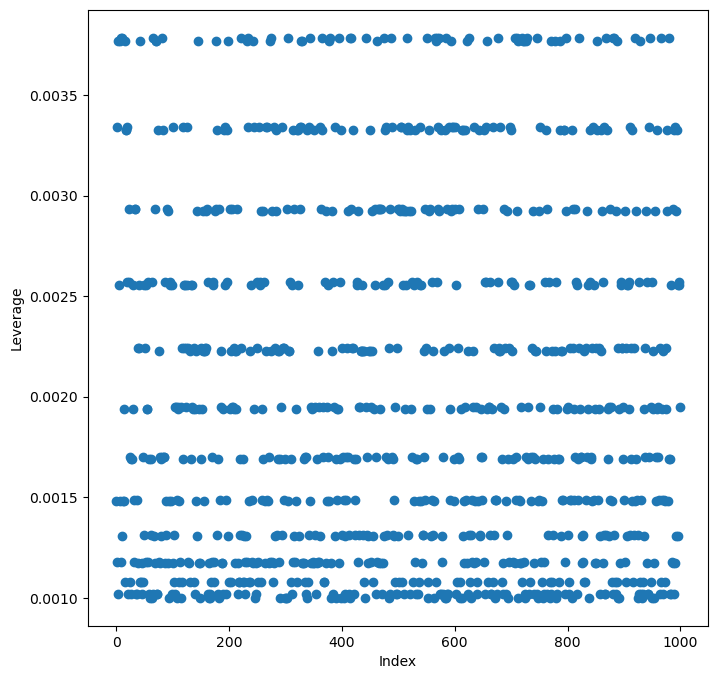

In [ ]:
# Compute leverage statistics
infl = results.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)
# Il livello di Leverage per gli outliers è 0.0040. Siccome quasi tutti i dati sono sotto la soglia possiamo dire che il modello è ben bilanciato,
# inoltre i dati hanno un’influenza relativamente bassa sul modello perchè hanno Leverage basso.

# Fit Linear Model: Delivery_Time_min = b0 + b1*Courier_Experience_yrs + e

In [63]:
# Alcuni righe hanno valore di Courier_Experience_yrs non definito, quindi li rimuoviamo

X = pd.DataFrame({'intercept': np.ones(Food.shape[0]), 'Courier_Experience_yrs': Food['Courier_Experience_yrs']})
X[:4]

y = Food['Delivery_Time_min']

X.isna().sum()       # mostra quanti NaN hai per colonna
np.isinf(X).sum()    # mostra quanti inf hai per colonna
y.isna().sum()
np.isinf(y).sum()

# Uniamo X e y temporaneamente per rimuovere righe con NaN o inf
data = pd.concat([X, y], axis=1)
data = data.replace([np.inf, -np.inf], np.nan)  # converte gli inf in NaN
data = data.dropna()

# Ricostruisci X e y puliti
X_clean = data[['intercept', 'Courier_Experience_yrs']]
y_clean = data['Delivery_Time_min']

model = sm.OLS(y_clean, X_clean) #function to fit a simple linear regression. Here we define the model
results = model.fit() #here we fit the model

In [ ]:
summarize(results) #produces a simple table of the parameter estimates, their standard errors, t-statistics and p-values
# Courier_Experience_yrs ha Pvalue = 0.005, quindi è piuttosto rilevante. 
# Il coefficiente è negativo, quindi all'aumentare dell'esperienza diminuisce il tempo di attesa. 
# L'intercetta ha un valore alto, quindi l'esperienza è rilevante ma da solo non spiega sufficientemente i tempi di consegna

,coef,std err,t,P>|t|
intercept,59.8796,1.316,45.513,0.000
Courier_Experience_yrs,-0.6849,0.242,-2.825,0.005


### Creating the input matrix using ModelSpec of ISLP package

In [65]:
model = MS(['Courier_Experience_yrs'])
model = model.fit(Food) #checks that the lstat column is present in the Boston dataset
X = model.transform(Food)#constructs the input matrix with the intercept column
#NB: These two methods can be combined in a single method called fit_transform and can also handle more complex cases of pre-processing
X[:4]

,intercept,Courier_Experience_yrs
0,1.0,1.0
1,1.0,2.0
2,1.0,1.0
3,1.0,1.0


In [66]:
#Get predictions on new input
new_df = pd.DataFrame({'Courier_Experience_yrs':[1, 3, 5, 7, 10]})
newX = model.transform(new_df) #create the new data matrix with the transform method of the previously defined model
newX

,intercept,Courier_Experience_yrs
0,1.0,1
1,1.0,3
2,1.0,5
3,1.0,7
4,1.0,10


In [67]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([59.19470491, 57.82496772, 56.45523053, 55.08549334, 53.03088755])

In [68]:
#Confidence interval
new_predictions.conf_int(alpha=0.05)

array([[56.99932564, 61.39008418],
       [56.24866282, 59.40127262],
       [55.05513793, 57.85532313],
       [53.28375623, 56.88723044],
       [50.10344952, 55.95832558]])

C:\Users\Asus\AppData\Local\Temp\ipykernel_15452\1075242893.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)


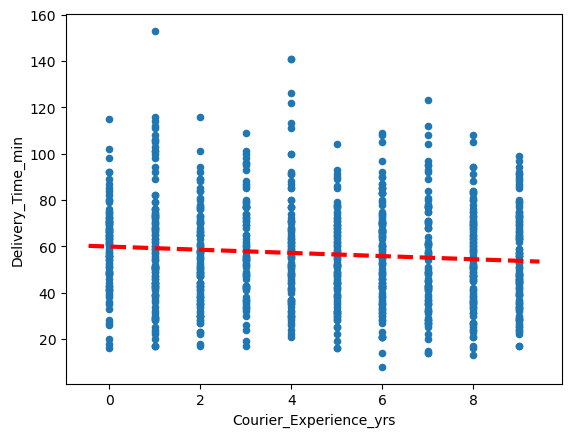

In [ ]:
#Plotting the regression line
def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = Food.plot.scatter('Courier_Experience_yrs', 'Delivery_Time_min')
abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)

# I punti sono molto dispersi attorno alla retta, quindi il modello non spiega bene la variabilità dei dati.
# Anche a parità di esperienza (es. 3, 5 o 7 anni), il tempo di consegna può variare da 20 a oltre 120 minuti.
# Per ogni valore di Courier_Experience_yrs, c’è una forte sovrapposizione verticale sintomo che molti altri fattori oltre all’esperienza influiscono sul tempo di consegna.

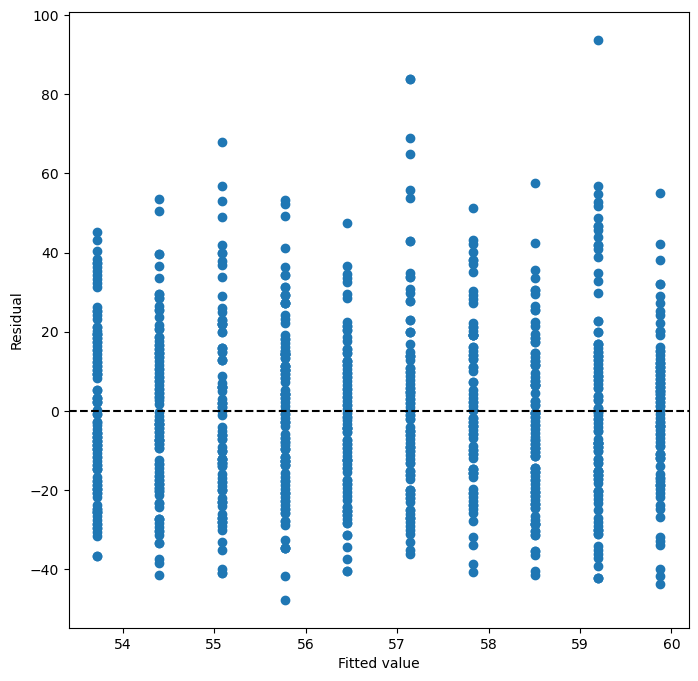

In [ ]:
# Diagnostics plot (We observe non linearity)
fig, ax = plt.subplots(figsize=(8, 8)) 
ax.scatter(results.fittedvalues, results.resid)  # Scatter plot of fitted values vs residuals
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')  
# I residui sono molto grandi quindi scarsa accuratezza, l'esperienza pare essere rilevante ma da solo non spiega sufficientemente i tempi di consegna

np.int64(19)

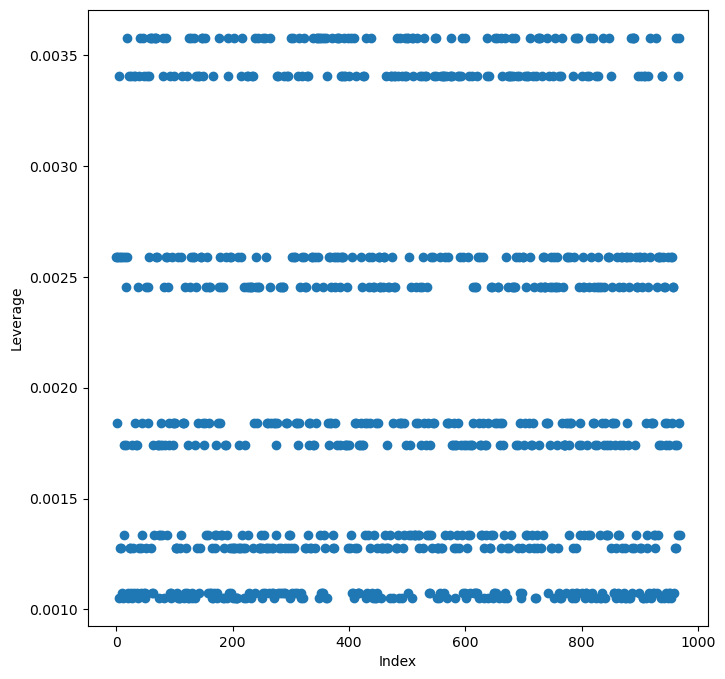

In [ ]:
# Compute leverage statistics
infl = results.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X_clean.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

# Nessun punto ha Leverage elevata, quindi nessun punto domina la stima del modello.
# Questo è positivo, ma conferma anche che nessuna singola osservazione riesce a dare una forte informazione al modello, 
# il che è coerente col fatto che il modello non spiega bene la variabilità nei dati.

# Multiple Linear Regression
y = b0 + b1 * Distance_km + b2 * Preparation_Time_min + b3 * Courier_Experience_yrs + e

In [78]:
# X contiene già 'intercept' se l'hai fatto con MS = sm.add_constant o simili
X = MS(['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']).fit_transform(Food)
y = Food['Delivery_Time_min']

# Unisci X e y in un unico DataFrame
data = pd.concat([X, y], axis=1)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

# Ricrea X_clean e y_clean con indici allineati
X_clean = data[['intercept', 'Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']]
y_clean = data['Delivery_Time_min']

# Fit del modello
model1 = sm.OLS(y_clean, X_clean)
results1 = model1.fit()
summarize(results1)


,coef,std err,t,P>|t|
intercept,12.5702,1.353,9.289,0.0
Distance_km,3.0269,0.067,45.040,0.0
Preparation_Time_min,0.9604,0.053,18.084,0.0
Courier_Experience_yrs,-0.5654,0.131,-4.308,0.0


In [ ]:
# y = b*X + e (perform a regression using all of the predictors)
terms = Food.columns.drop('medv')
print(terms)

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat'],
      dtype='object')


In [14]:
X = MS(terms).fit_transform(Boston)
model = sm.OLS(y, X)
results = model.fit()
summarize(results)
# PER PROGETTO: aggiungere una colonna alla volta

,coef,std err,t,P>|t|
intercept,41.6173,4.936,8.431,0.000
crim,-0.1214,0.033,-3.678,0.000
zn,0.0470,0.014,3.384,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8400,0.870,3.264,0.001
nox,-18.7580,3.851,-4.870,0.000
rm,3.6581,0.420,8.705,0.000
age,0.0036,0.013,0.271,0.787
dis,-1.4908,0.202,-7.394,0.000
rad,0.2894,0.067,4.325,0.000


In [79]:
# getting goodness of fit
print("R2", results1.rsquared) # meglio se alto, 0.7 è alto
print("RSE", np.sqrt(results1.scale))

R2 0.710221554312955
RSE 11.899680321660957


## Qualitative predictors
Based on the Carseats dataset present in the package ISLP, will attempt to predict Sales (child car seat sales) in 400 locations based
on a number of predictors.

The Carseats data includes the qualitative predictor "ShelveLoc," which indicates the quality of the shelving location with three possible values: Bad, Medium, and Good.

In general for qualitative predictor the ModelSpec() generates one-hot encoding of the categorical variables automatically

In [40]:
Carseats = load_data('Carseats')
Carseats.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [ ]:
allvars = list(Carseats.columns.drop('Sales'))
y = Carseats['Sales']
final = allvars + [('Income', 'Advertising'),
('Price', 'Age')]
X = MS(final).fit_transform(Carseats)
model = sm.OLS(y, X)
summarize(model.fit())
#ShelveLoc[Bad] è scelto come base, se ho Medium incremento di 1.9, Good incremento 4.8. Stessa cosa per Urban e US

,coef,std err,t,P>|t|
intercept,6.5756,1.009,6.519,0.000
CompPrice,0.0929,0.004,22.567,0.000
Income,0.0109,0.003,4.183,0.000
Advertising,0.0702,0.023,3.107,0.002
Population,0.0002,0.000,0.433,0.665
Price,-0.1008,0.007,-13.549,0.000
ShelveLoc[Good],4.8487,0.153,31.724,0.000
ShelveLoc[Medium],1.9533,0.126,15.531,0.000
Age,-0.0579,0.016,-3.633,0.000
Education,-0.0209,0.020,-1.063,0.288


# Cross Validation

### Validation set approach

In [2]:
from functools import partial
from sklearn.model_selection import (cross_validate ,KFold ,ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm #a wrapper that enables us to easily use the cross-validation tools of sklearn with models fit by statsmodels
from sklearn.model_selection import train_test_split

In [7]:
Auto = load_data('Auto')
Auto_train , Auto_valid = train_test_split(Auto, test_size=196, random_state=0) # random_state is needed for reproducible result across run

In [8]:
#fit a linear regression model
hp_mm = MS(['horsepower'])
X_train = hp_mm.fit_transform(Auto_train)
y_train = Auto_train['mpg']
model = sm.OLS(y_train , X_train)
results = model.fit()

In [9]:
# evaluate the model using the MSE on the validation data
X_valid = hp_mm.transform(Auto_valid)
y_valid = Auto_valid['mpg']
valid_pred = results.predict(X_valid)
np.mean((y_valid - valid_pred)**2)
#Con questa tecnica il mean squared error è molto variabile perchè abbiamo preso random metà del dataset. Quelli sotto sono più precisi

np.float64(23.61661706966988)

## Leave One-out Cross validation
The sklearn_sm() class takes a statsmodels model as its first argument. It also accepts two optional arguments: model_str for specifying a formula, and model_args, which is a dictionary containing additional arguments for fitting the model.

In [ ]:
hp_model = sklearn_sm(sm.OLS, MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']

# This is a LOOCV because cv use the number of sample in our dataset, that is Auto.shape[0], making sure that each sample is use as a test set
cv_results = cross_validate(hp_model ,X, Y, cv=Auto.shape[0]) # Con cv imposto la fold uguale a n, ogni volta toglie 1 elemento dal dataset
cv_err = np.mean(cv_results['test_score'])
cv_err 
# Questo metodo è il più preciso ma il più lento

np.float64(24.231513517929216)

## K-Fold cross validation

In [ ]:
hp_model = sklearn_sm(sm.OLS, MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_validate(hp_model, X, Y, cv=kf)
cv_err = np.mean(cv_results['test_score'])
cv_err
# Via di mezzo tra i due precedenti

np.float64(24.09767573188305)

# Exercise
Train and compare the performance of different cross-validation methods to identify the best model for polynomial regression with varying degrees using the Auto dataset.

https://scikit-learn.org/stable/